# Prep

## Imports

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pprint
import json
import os
import re

#from dotenv import load_dotenv
from bs4 import BeautifulSoup
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt

## Auth

In [169]:
#load_dotenv(r"C:\\Users\\User\\Documents\\GitHub\\movies\\tmdb_auth.env")

#api_key = os.getenv("API_KEY")
#access_token = os.getenv("ACCESS_TOKEN")

# TMDB API Data

In [170]:
hold = '''
tmdb_url = "https://api.themoviedb.org/3/account/21623434/rated/movies?language=en-US&page=1&sort_by=created_at.asc"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {access_token}"
}
'''

#response = requests.get(tmdb_url, headers=headers)


In [171]:
#data = json.loads(response.text)
#data['results']

# Scrape Letterboxd Data

## Functions

### Extraction and general structuring

In [172]:
# reads through a Letterboxd list and gets the url for each movie in it

def get_film_urls(list_url):
    content = requests.get(list_url).text
    soup = BeautifulSoup(content, 'html')

    url_list = [div['data-target-link'] for div in soup.find_all('div', class_='film-poster')]

    return url_list

In [173]:
# extracts the complete, raw HTML fom a URL

def get_raw_film_html(film_url):
    url = "https://letterboxd.com" + film_url
    content = requests.get(url).text
    soup = BeautifulSoup(content, 'html.parser')

    return soup

In [174]:
# goes through the raw HTML. extracts and structures general data and metadata about the film 

def get_general_film_data(soup):
    duration_string = soup.find(class_='text-footer').get_text().replace('\xa0', ' ').strip()

    general_data = {
        'letterboxd_id': soup.find(id='backdrop')['data-film-id'],
        'letterboxd_shorttitle': soup.find('h1', class_='filmtitle').get_text(),
        'letterboxd_longtitle': soup.find(property='og:title')['content'],
        'letterboxd_slug': soup.find(id='backdrop')['data-film-slug'],
        'letterboxd_url': soup.find(property='og:url')['content'],
        'imdb_url': soup.find('a', {'data-track-action': 'IMDb'})['href'],
        'tmdb_url': soup.find('a', {'data-track-action': 'TMDb'})['href'],
        'tmdb_id': '',
        'release_year': soup.find(class_='releaseyear').find('a').get_text(strip=True),
        'duration': re.search(r'(\d+)\s+mins', duration_string).group(1),
        'avg_rating': soup.find('meta', attrs={'name': 'twitter:data2'})['content'].split(' out')[0]
    }

    general_data['tmdb_id'] = general_data['tmdb_url'].split('/')[-2]

    return general_data

In [175]:
# goes through the raw HTML. extracts and structures data about the movie's cast

def get_film_cast(soup):
    cast_list = []
    cast = soup.find(name='div', class_='cast-list').find_all('a', class_='tooltip')

    for member in cast:
        cast_member_info = {
            'name': member.get_text(strip=True),
            'link': member['href']
            #'character_name': member['title']
        }

        try:
            cast_member_info['character_name'] = member['title']
        except:
            cast_member_info['character_name'] = None
        cast_list.append(cast_member_info)

    return cast_list

In [176]:
# goes through the raw HTML. extracts and structures data about the movie's crew

def get_film_crew(soup):
    crew_list = []
    crew = soup.find(id='tab-crew').find_all('a')

    for member in crew:
        split_link = member['href'].split('/')
        
        crew_member_info = {
            'name': member.get_text(strip=True),
            'role': split_link[1],
            'link': member['href'],
        }
        crew_list.append(crew_member_info)
    
    return crew_list

In [177]:
# goes through the raw HTML. extracts and structures data about other details concerning the movie

def get_film_details(soup):
    details_list = []
    details = soup.find(id='tab-details').find_all('a')

    for detail in details:
        split_link = detail['href'].split('/')

        detail_info = {
            'key': '',
            'value': detail.get_text(strip=True),
            'link': detail['href']
        }

        if 'studio' in detail['href']:
            detail_info['key'] = 'studio'
        elif 'country' in detail['href']:
            detail_info['key'] = 'country'
        elif 'language' in detail['href']:
            detail_info['key'] = 'language'
        else:
            detail_info['key'] = 'ERROR'
        details_list.append(detail_info)

    return details_list

In [178]:
# goes through the raw HTML. extracts and structures data about the movie's genres and themes

def get_film_genres(soup):
    genres = [a_tag.get_text(strip=True) for a_tag in soup.find(id='tab-genres').find_all('a')]

    return genres[:-1]

In [179]:
# creates a loop using the previous functions to extract all the relevant data and unify it in a dict

def get_complete_film_data(film_url):
    film_soup = get_raw_film_html(film_url)

    film_data = {
        'general_data': get_general_film_data(film_soup),
        'cast': get_film_cast(film_soup),
        'crew': get_film_crew(film_soup),
        'details': get_film_details(film_soup),
        'genres_and_themes': get_film_genres(film_soup)
    }

    return film_data

In [180]:
# loops through all URLs in a list, extracting and structuring data from all of them

def get_all_films(url_list):
    whole_data = []

    counter = 0
    for film in url_list:
        #print(f"Extracting from URL #{counter}:\n{film}\n")
        whole_data.append(get_complete_film_data(film))
        counter += 1
    
    return whole_data

In [181]:
# transforms the data dictionaries into dataframes

def dicts_to_dfs(data):
    all_dfs_gdata = [] # general data
    all_dfs_cast = []
    all_dfs_crew = []
    all_dfs_details = []
    all_dfs_gthemes = []


    for film in data:
        id = film['general_data']['letterboxd_id']
        title = film['general_data']['letterboxd_shorttitle']
        
        single_df_gdata = pd.DataFrame.from_dict([film['general_data']])
        all_dfs_gdata.append(single_df_gdata)

        single_df_cast = pd.DataFrame.from_dict(film['cast']).assign(film_id = id, film_title = title)
        all_dfs_cast.append(single_df_cast)

        single_df_crew = pd.DataFrame.from_dict(film['crew']).assign(film_id = id, film_title = title)
        all_dfs_crew.append(single_df_crew)

        single_df_details = pd.DataFrame.from_dict(film['details']).assign(film_id = id, film_title = title)
        all_dfs_details.append(single_df_details)

        single_df_gthemes = pd.DataFrame.from_dict(film['genres_and_themes']).assign(film_id = id, film_title = title)
        all_dfs_gthemes.append(single_df_gthemes)

    all_dfs_dict = {
        'df_gdata': pd.concat(all_dfs_gdata),
        'df_cast': pd.concat(all_dfs_cast),
        'df_crew': pd.concat(all_dfs_crew),
        'df_details': pd.concat(all_dfs_details),
        'df_gthemes': pd.concat(all_dfs_gthemes)
    }

    return all_dfs_dict

### Other treatments

# Extract, create and treat DFs

In [182]:
#film_urls = get_film_urls("https://letterboxd.com/dromemario/list/fff-film-fueled-friends/")

#films_data = get_all_films(film_urls)

#with open("films_data.json", "w") as json_file:
#    json.dump(films_data, json_file, indent=4)

In [183]:
with open("films_data.json", "r") as json_file:
    films_data = json.load(json_file)

In [184]:
all_dfs_dict = dicts_to_dfs(films_data)

In [185]:
df_gdata = (
    all_dfs_dict['df_gdata'][[
        'letterboxd_id',
        'letterboxd_shorttitle',
        'letterboxd_longtitle',
        'letterboxd_slug',
        'tmdb_id',
        'release_year',
        'duration',
        'avg_rating',
        'letterboxd_url',
        'tmdb_url',
        'imdb_url'
        ]]
    .astype({
        'release_year': 'int64',
        'duration': 'int64',
        'avg_rating': 'float64',
        'letterboxd_url': 'string',
        'tmdb_url': 'string',
        'imdb_url': 'string'
        })
    .reset_index(drop=True)
)

df_cast = (
    all_dfs_dict['df_cast'][[
        'film_id',
        'film_title',
        'name',
        'link',
        'character_name'
    ]]
    .assign(link = 'letterboxd.com' + all_dfs_dict['df_cast']['link'])
    .reset_index(drop=True)
    .astype({'link': 'string'})
)

df_crew = (
    all_dfs_dict['df_crew'][[
        'film_id',
        'film_title',
        'name',
        'role',
        'link',
    ]]
    .assign(link = 'letterboxd.com' + all_dfs_dict['df_crew']['link'])
    .reset_index(drop=True)
    .astype({'link': 'string'})
)

df_details = (
    all_dfs_dict['df_details'][[
        'film_id',
        'film_title',
        'key',
        'value',
        'link',
    ]]
    .assign(link = 'letterboxd.com' + all_dfs_dict['df_details']['link'])
    .reset_index(drop=True)
    .astype({'link': 'string'})
)

df_gthemes = (
    all_dfs_dict['df_gthemes'].rename(columns={0: 'value'})[[
        'film_id',
        'film_title',
        'value'
    ]]
    .reset_index(drop=True)
)

# Generate Analytical Dataframes

In [186]:
analytical_dataframes = {}

## General data

In [187]:
df_gdata['release_decade'] = (df_gdata['release_year'] // 10) * 10

In [188]:
#df_gdata.head(3)

In [189]:
median_rating = df_gdata['avg_rating'].median()
closest_to_median_row = df_gdata.iloc[(df_gdata['avg_rating'] - median_rating).abs().idxmin()]

main_metrics_dict = {
    'movies_watched': len(df_gdata),
    'minutes_watched': int(df_gdata['duration'].sum()),
    'hours_watched': float((df_gdata['duration'].sum() / 60).round(2)),
    'days_watched': float(((df_gdata['duration'].sum() / 60) / 24).round(2)),
    'avg_movie_length': float(df_gdata['duration'].mean().round(2)),
    'name_longest_movie': df_gdata.loc[df_gdata['duration'].idxmax()]['letterboxd_shorttitle'],
    'duration_longest_movie': int(df_gdata['duration'].max().round(2)),
    'name_shortest_movie': df_gdata.loc[df_gdata['duration'].idxmin()]['letterboxd_shorttitle'],
    'duration_shortest_movie': int(df_gdata['duration'].min().round(2)),
    'avg_lbxd_rating': float(df_gdata['avg_rating'].mean().round(2)),
    'best_lbxd_rating': df_gdata.loc[df_gdata['avg_rating'].idxmax()]['letterboxd_shorttitle'],
    'worst_lbxd_rating': df_gdata.loc[df_gdata['avg_rating'].idxmin()]['letterboxd_shorttitle']
}

analytical_dataframes['main_metrics'] = pd.DataFrame([main_metrics_dict])

#analytical_dataframes['main_metrics']

In [190]:
adf_moviesperdecade = df_gdata.groupby('release_decade')[['letterboxd_id']].count().reset_index().rename(columns={'letterboxd_id': 'movie_count'})
missing_decades = pd.DataFrame({'release_decade': [1930], 'movie_count': [0]})

analytical_dataframes['movies_per_release_decade'] = (
    pd.concat([adf_moviesperdecade, missing_decades])
    .sort_values('release_decade')
    .reset_index(drop=True)
)

#analytical_dataframes['movies_per_release_decade']

## Cast

In [191]:
analytical_dataframes['popular_actors'] = (
    df_cast
    .groupby(['link', 'name'])[['film_id']].count().reset_index()
    .rename(columns={'film_id': 'movie_count'})
    .sort_values('movie_count', ascending=False)
    .query(" movie_count > 2 ")
    .reset_index(drop=True)
)[['name', 'movie_count', 'link']]


most_popular_actors = list(analytical_dataframes['popular_actors']['name'])

analytical_dataframes['popular_actors_movies'] = (
    df_cast[['name', 'film_title']]
    .loc[df_cast['name'].isin(most_popular_actors)]
    .sort_values(['name', 'film_title'], ascending=[False, True])
)

#analytical_dataframes['popular_actors']
#analytical_dataframes['popular_actors_movies']

## Crew

In [192]:
adf_crew_moviesperrole = (
    df_crew
    .groupby(['link', 'name', 'role'])[['film_id']].count().reset_index()
    .rename(columns={'film_id': 'movie_count'})
    .sort_values(['role', 'movie_count'], ascending=[True,False])
    .query(" movie_count > 1 ")
    .reset_index(drop=True)
)[['name', 'role', 'movie_count', 'link']]

#adf_crew_moviesperrole

In [201]:
main_roles = ['director', 'writer']
secondary_roles = ['producer', 'executive-producer', 'editor', 'cinematography', 'composer']

for role in (main_roles):
    analytical_dataframes[f'popular_{role}s'] = adf_crew_moviesperrole.query(f" role == '{role}' ").drop(columns='role')

    most_popular_in_role = list(analytical_dataframes[f'popular_{role}s']['name'])

    analytical_dataframes[f'popular_{role}s_movies'] = (
        df_crew[['name', 'role', 'film_title']]
        .loc[df_crew['name'].isin(most_popular_in_role)]
        .query(f" role == '{role}' ")
        .sort_values(['name', 'film_title'], ascending=[False, True])
        .drop(columns='role')
    )

In [202]:
#analytical_dataframes['popular_writers']
#analytical_dataframes['popular_executive-producers_movies']

In [203]:
adf_secondaryroles = (
    adf_crew_moviesperrole
    .loc[adf_crew_moviesperrole['role'].isin(secondary_roles)]
    .sort_values(['movie_count', 'role'], ascending=[False, True])
)

In [204]:
#adf_secondaryroles

In [205]:
adf_terciaryroles = (
    adf_crew_moviesperrole
    .loc[~adf_crew_moviesperrole['role'].isin(main_roles+secondary_roles)]
    .sort_values(['movie_count', 'role'], ascending=[False, True])
)

#adf_terciaryroles

In [206]:
terciary_crew = [170, 121, 270, 13, 77, 6, 36, 115]
most_popular_crew = adf_terciaryroles.loc[terciary_crew]['link']

kkkkloiasdas = '''
analytical_dataframes['popular_crew_movies'] = (
    df_crew[['name', 'role', 'film_title']]
    .loc[df_crew['link'].isin((most_popular_crew))]
    .sort_values(['name', 'film_title'], ascending=[False, True])
)
'''

#analytical_dataframes['popular_crew_movies']

## Details

In [207]:
df_details = df_details.drop_duplicates(subset=['film_id', 'film_title', 'key', 'value', 'link'], keep='first').reset_index(drop=True)

In [208]:
df_details['movie_count'] = df_details.groupby('link')['link'].transform('count')

In [209]:
df_studios = (
    df_details
    .loc[df_details['key'] == 'studio']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'studio'})
)

df_countries = (
    df_details
    .loc[df_details['key'] == 'country']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'country'})
)

df_languages = (
    df_details
    .loc[df_details['key'] == 'language']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'language'})
)

In [210]:
analytical_dataframes['movies_per_country'] = (
    df_countries
    .groupby('country')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

In [211]:
analytical_dataframes['movies_per_language'] = (
    df_languages
    .groupby('language')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

In [212]:
analytical_dataframes['movies_per_studio'] = (
    df_studios
    .groupby('studio')[['movie_count']].max().reset_index()
    .query(" movie_count > 2 ")
    .sort_values('movie_count', ascending=False)
)

## Genres and Themes

In [213]:
df_gthemes['movie_count'] = df_gthemes.groupby('value')['value'].transform('count')

In [214]:
genres = [
    'Adventure',
    'Family',
    'Drama',
    'Comedy',
    'Fantasy',
    'Action',
    'Horror',
    'Mystery',
    'Thriller',
    'Science Fiction',
    'Crime',
    'Western',
    'Animation',
    'History',
    'Romance',
    'Music'
]

df_genres = df_gthemes.loc[df_gthemes['value'].isin(genres)].rename(columns={'value': 'genre'})
df_themes = df_gthemes.loc[~df_gthemes['value'].isin(genres)].rename(columns={'value': 'theme'})

df_genres['primary_genre'] = df_genres.groupby('film_title').cumcount() == 0
df_themes['primary_theme'] = df_themes.groupby('film_title').cumcount() == 0

In [215]:
analytical_dataframes['popular_complete_genres'] = (
    df_genres
    .groupby('genre')[['film_title']].count().reset_index()
    .sort_values('film_title', ascending=False)
)

#analytical_dataframes['popular_complete_genres']

In [216]:
analytical_dataframes['popular_primary_genres'] = (
    df_genres
    .query(" primary_genre == True ")
    .groupby('genre')[['film_title']].count().reset_index()
    .sort_values('film_title', ascending=False)
)

#analytical_dataframes['popular_primary_genres']

In [217]:
analytical_dataframes['popular_themes'] = (
    df_themes
    .groupby('theme')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

#analytical_dataframes['popular_themes']

# Presentation

### Display Functions

In [218]:
def display_presentation_title():
    display(HTML(f"<div style='font-size:128px'>Film-Fueled-Friends: Wrapped</div><div style='font-size:36px'>Uma análise do nosso histórico de cinefilia entre amigos</div>"))

In [219]:
def display_presentation_objectives():
    objectives = """

    <div>
        <h1 style='font-size:64px; font-weight:bold'>Objetivos da apresentação</h1>
        <ul style='font-size:32px'>- Trazer dados curiosos sobre os filmes que assistimos</ul>
        <ul style='font-size:32px'>- Sugerir roadmap de filmes futuros</ul>
        <ul style='font-size:32px'>- Incentivar o Jhones a usar o Letterboxd</ul>
    </div>

    """
    display(HTML(objectives))

In [220]:
def display_single_general_metric(title, value):
    display_value = str(analytical_dataframes['main_metrics'][f'{value}'].iloc[0])
    display(HTML(f"<div style='font-size:24px'>{title}</div><div style='font-size:128px; font-weight:bold'>{display_value}</div>"))

In [221]:
def display_person_data(role, row_index):
    df_data = analytical_dataframes[f'popular_{role}s']
    df_movies = analytical_dataframes[f'popular_{role}s_movies']
    persons_data = df_data.iloc[row_index]
    url = "https://www." + persons_data['link']
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')

    image_tag = soup.find('img', class_='js-tmdb-person')
    image_url = image_tag['data-image'] if image_tag else None

    img_response = requests.get(image_url)
    img_response.raise_for_status()

    display(Image(img_response.content))
    display(HTML(f"<div style='font-size:24px'>{persons_data['name']}: {persons_data['movie_count']} filmes</div>"))

    movie_list = df_movies.query(f" name == '{persons_data['name']}' ")['film_title']
    [print(movie) for movie in movie_list]

In [222]:
def pull_whole_crew_data(role):
    total_people = len(analytical_dataframes[f'popular_{role}s'])
    i = 0
    while i < (total_people):
        display_person_data(role, i)
        i += 1

## Intro

In [223]:
display_presentation_title()

In [224]:
display_presentation_objectives()

## General Data

### Movies Watched

In [225]:
display_single_general_metric('Filmes Assistidos', 'movies_watched')
display_single_general_metric('Minutos Assistidos', 'minutes_watched')
display_single_general_metric('Horas Assistidas', 'hours_watched')
display_single_general_metric('Dias Assistidos', 'days_watched')

### Movie Length

In [226]:
display_single_general_metric('Duração Média de Filme', 'avg_movie_length')

In [227]:
display_single_general_metric('Filme Mais Longo', 'name_longest_movie')
display_single_general_metric('Duração', 'duration_longest_movie')

In [228]:
display_single_general_metric('Filme Mais Curto', 'name_shortest_movie')
display_single_general_metric('Duração', 'duration_shortest_movie')

### Letterboxd Ratings

In [229]:
display_single_general_metric('Nota Média no Letterboxd', 'avg_lbxd_rating')
display_single_general_metric('Filme com Melhores Notas', 'best_lbxd_rating')
display_single_general_metric('Filme com Piores Notas', 'worst_lbxd_rating')

### Movies per decade

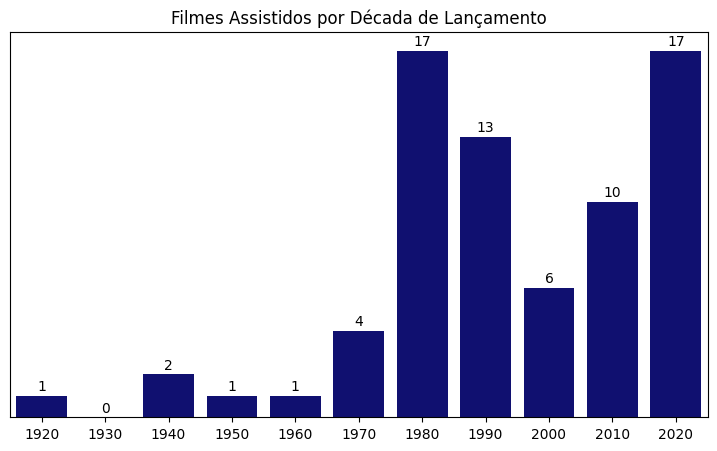

In [268]:
gdf_mpd = analytical_dataframes['movies_per_release_decade']

plt.figure(figsize=(9, 5))
sns.barplot(data=gdf_mpd, x='release_decade', y='movie_count', color='navy')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Filmes Assistidos por Década de Lançamento')

for index, row in gdf_mpd.iterrows():
    plt.text(x=index, y=row['movie_count'] + 0.1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.show()

## Cast

### Individual Data

In [231]:
#pull_whole_crew_data('actor')

### Bar Chart

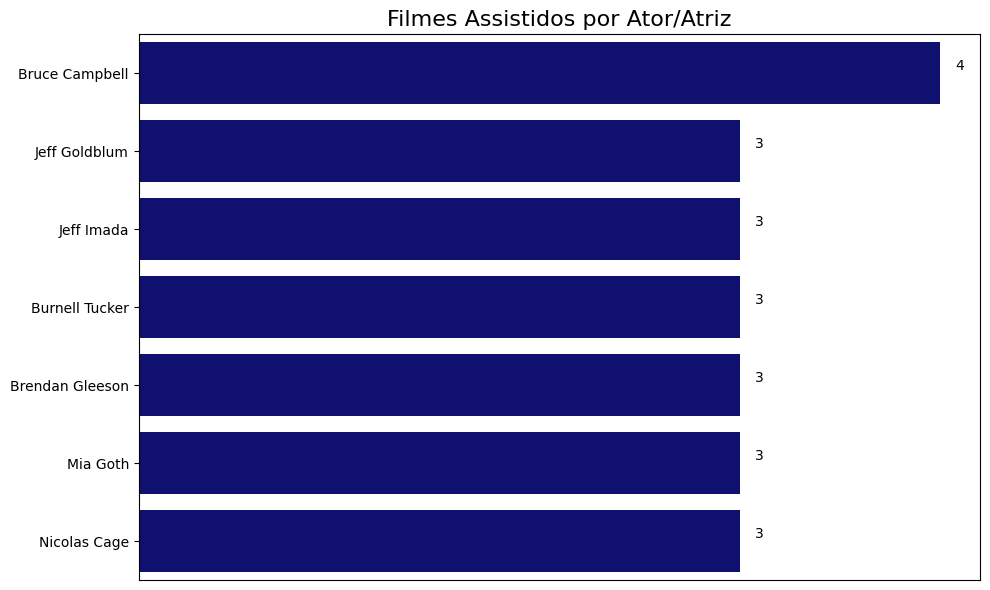

In [269]:
gdf_pa = analytical_dataframes['popular_actors'].drop(columns='link')

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_pa, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Ator/Atriz", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pa.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Directors

### Individual Data

In [233]:
#pull_whole_crew_data('director')

### Bar Chart

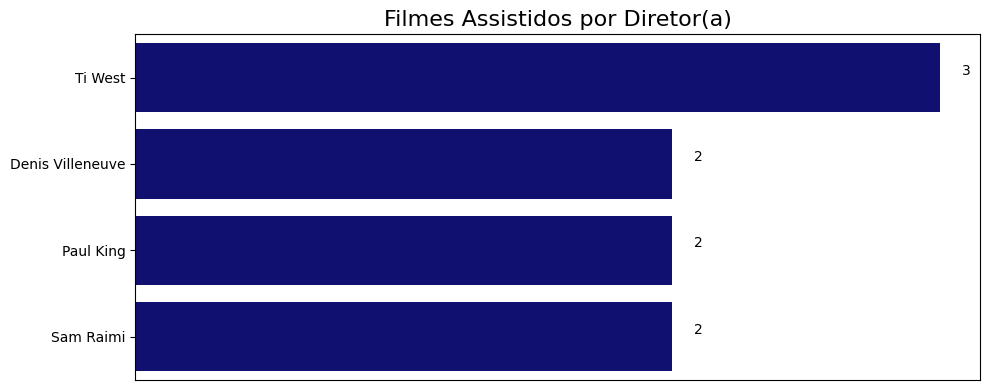

In [273]:
gdf_pd = analytical_dataframes['popular_directors'].drop(columns='link').reset_index()

# Create the horizontal bar chart
plt.figure(figsize=(10, 4))
sns.barplot(data=gdf_pd, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Diretor(a)", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pd.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Writers

In [235]:
#pull_whole_crew_data('writer')

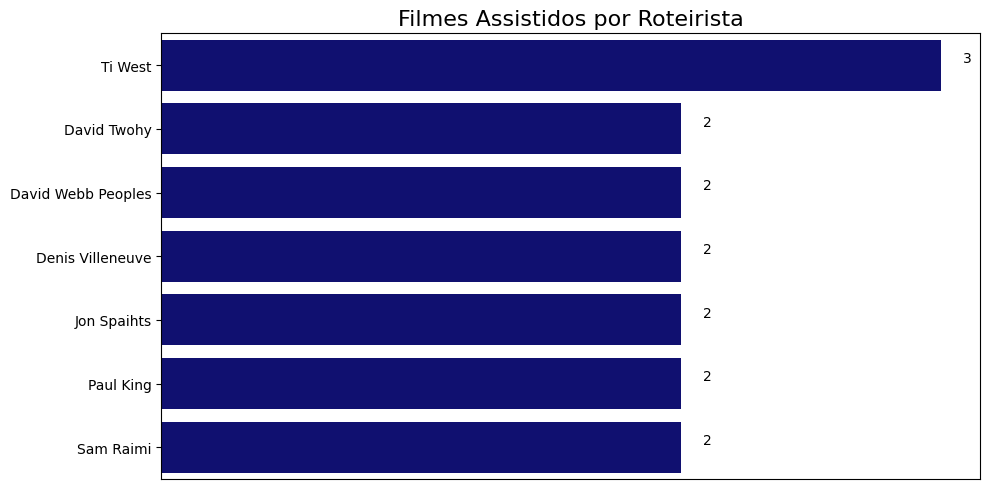

In [274]:
gdf_pw = analytical_dataframes['popular_writers'].drop(columns='link').reset_index()

# Create the horizontal bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=gdf_pw, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Roteirista", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pw.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Countries

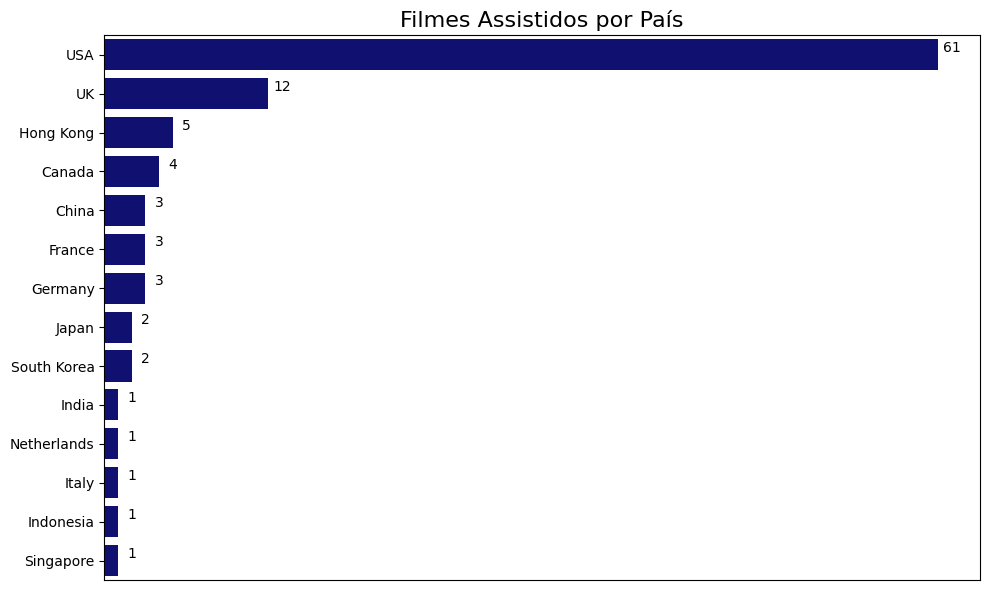

In [275]:
gdf_mpc = analytical_dataframes['movies_per_country'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_mpc, x="movie_count", y="country", color='navy')

plt.title("Filmes Assistidos por País", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mpc.iterrows():
    plt.text(y=index, x=row['movie_count'] + 1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Languages

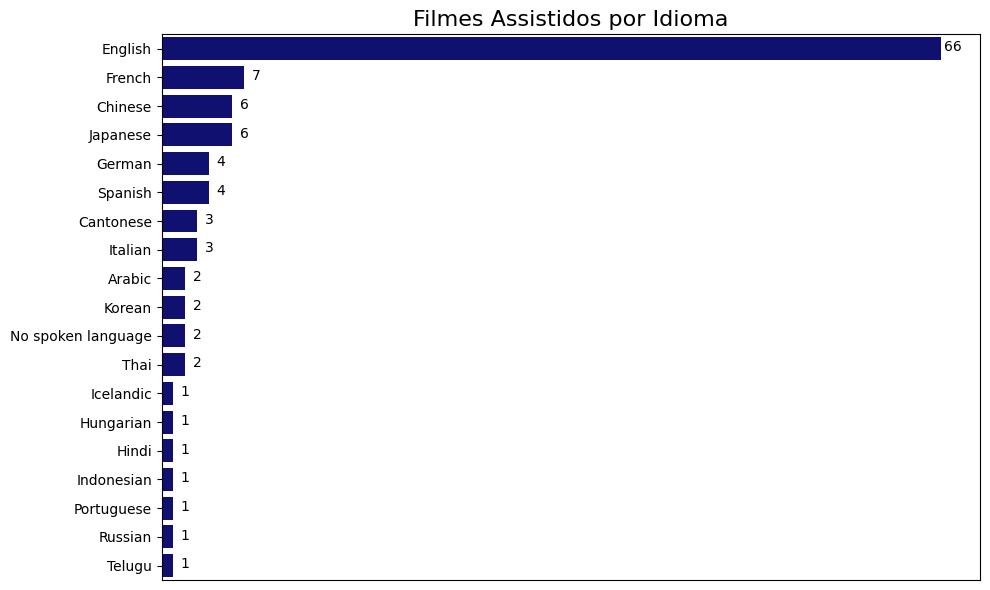

In [303]:
gdf_mpl = analytical_dataframes['movies_per_language'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_mpl, x="movie_count", y="language", color='navy')

plt.title("Filmes Assistidos por Idioma", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mpl.iterrows():
    plt.text(y=index + 0.2, x=row['movie_count'] + 1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Studios

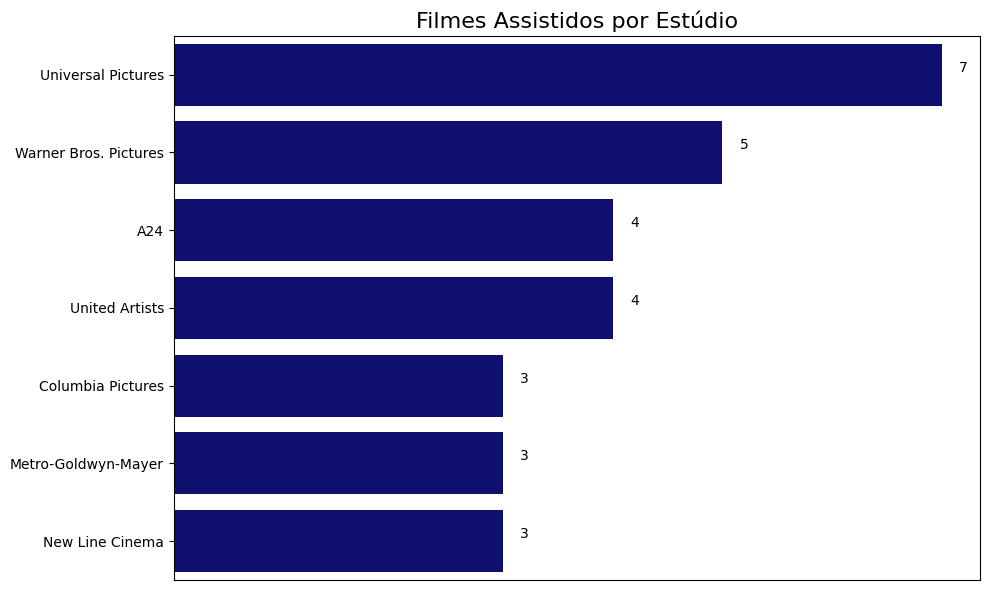

In [280]:
gdf_mps = analytical_dataframes['movies_per_studio'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=analytical_dataframes['movies_per_studio'], x="movie_count", y="studio", color='navy')

plt.title("Filmes Assistidos por Estúdio", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mps.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.2,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Genres and Themes

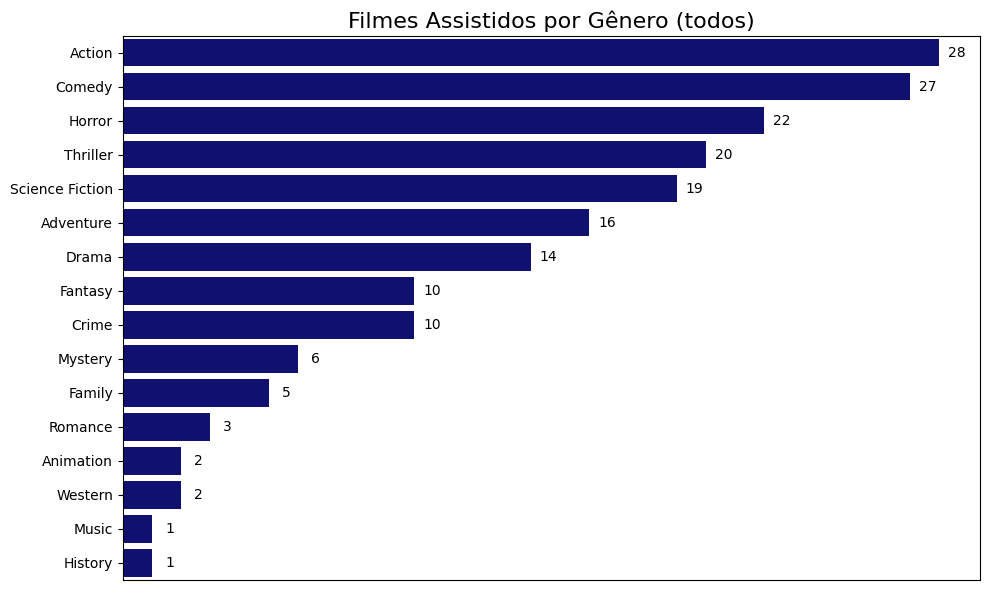

In [304]:
gdf_pcg = analytical_dataframes['popular_complete_genres'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_pcg, x="film_title", y="genre", color='navy')

plt.title("Filmes Assistidos por Gênero (todos)", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pcg.iterrows():
    plt.text(y=index + 0.2, x=row['film_title'] + 0.6,  # Position above the bar
             s=str(row['film_title']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

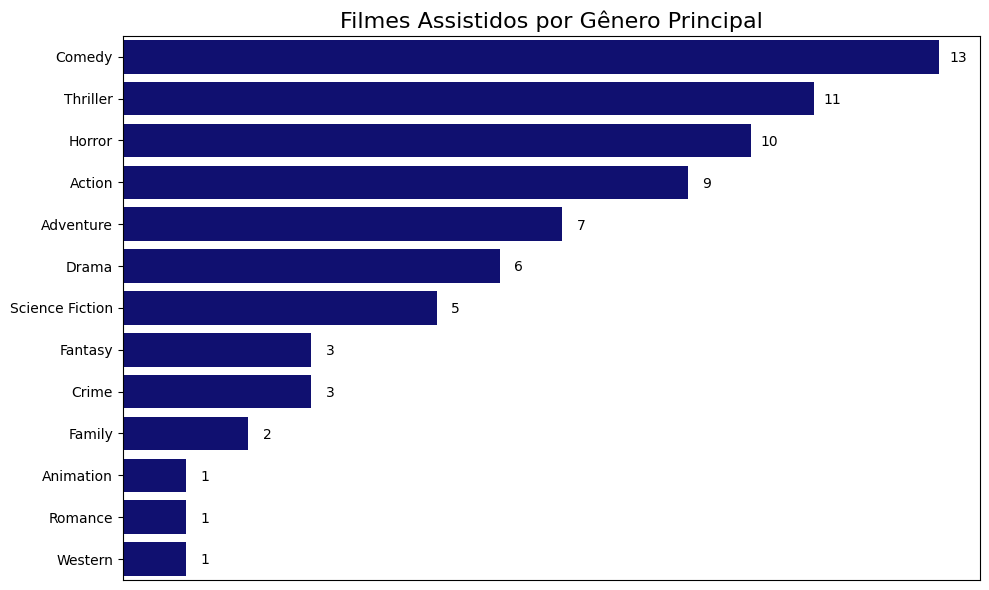

In [306]:
gdf_ppg = analytical_dataframes['popular_primary_genres'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_ppg, x="film_title", y="genre", color='navy')

plt.title("Filmes Assistidos por Gênero Principal", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_ppg.iterrows():
    plt.text(y=index + 0.2, x=row['film_title'] + 0.3,  # Position above the bar
             s=str(row['film_title']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

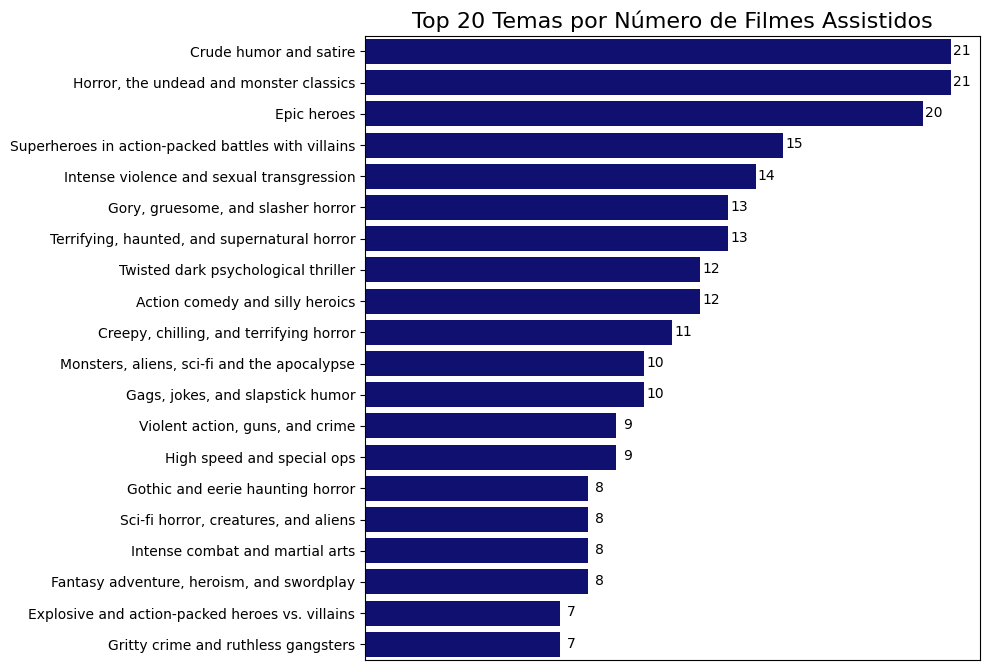

In [302]:
gdf_pt = analytical_dataframes['popular_themes'].reset_index().iloc[:20]

plt.figure(figsize=(10, 6.8))
sns.barplot(data=gdf_pt, x="movie_count", y="theme", color='navy')

plt.title("Top 20 Temas por Número de Filmes Assistidos", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pt.iterrows():
    plt.text(y=index + 0.2, x=row['movie_count'] + 0.4,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Roadmap

In [244]:
def display_suggestions():
    suggestions = """

    <div>
        <h1 style='font-size:64px; font-weight:bold'>Sugestões de filmes pro futuro</h1>
        <ul style='font-size:32px'>- <u>Um filme da década de 30</u> e <u>um da década de 60</u>, já que são as únicas faltando.</ul>
        <ul style='font-size:32px'>- <u>Dois filmes do Nicolas Cage</u>, para que ele tome seu lugar de direito.</ul>
        <ul style='font-size:32px'>- Pelo menos <u>um filme brasileiro</u> pra não dar vexame.</ul>
        <ul style='font-size:32px'>- Pra valorizar a indústria nacional, <u>mais filmes brasileiros</u>.</ul>
        <ul style='font-size:32px'>- Pra incentivar a equalidade, <u>mais filmes dirigidos por mulheres</u>.</ul>
        <ul style='font-size:32px'>- <u>Mais filmes musicais!</u></ul>
        <ul style='font-size:32px'>- <u>Jhones logar mais filmes!!!</u></ul>
    </div>

    """
    display(HTML(suggestions))

In [245]:
display_suggestions()

# Tests